In [226]:
import numpy as np
import itertools
import time
import collections
from Levenshtein import distance 

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer, util
from youtube_transcript_api import YouTubeTranscriptApi

import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

from gensim.summarization import keywords
from rake_nltk import Rake, Metric
from gensim.summarization.keywords import get_graph
import networkx as nx
import matplotlib.pyplot as plt
from random import randrange



In [2]:
# TODO
# Change delta? teacher talk slow
# Change Model
# Change input format (concat to a single string or stay splitted)
# Filter similarity output, one keyword per unique sentence?
# Size of dataset and how it affects TF-IDF

## Data Retrieval and Processing

In [3]:
def is_in_range(segment, time_low, time_high):
    segment_low = segment['start']
    segment_high = segment['start'] + segment['duration']
    
    if time_low <= segment_low <= time_high or time_low <= segment_high <= time_high:
        return True
    
    return False

def get_caption_segment(video_id, timestamp, duration, delta=15, concat_sentences=False):
    raw_transcript = YouTubeTranscriptApi.get_transcript(video_id)
    
    low_timestamp = max(timestamp - delta, 0)
    high_timestamp = min(timestamp + delta, duration)
    
    # Get rid of music
    filtered_transcript = list(filter(lambda e: e['text'] != '[Music]', raw_transcript))
    target_segment = filter(lambda e: is_in_range(e, low_timestamp, high_timestamp), filtered_transcript)
    text_segments = list(map(lambda e: e['text'], list(target_segment)))
    
    if concat_sentences:
        return " ".join(text_segments)
    
    return text_segments

In [4]:
video_id = "vd0fMpAIs1s"
timestamp = 90
duration = 255
text = get_caption_segment(video_id, timestamp, duration, delta = 5)

In [5]:
text

['came to America',
 'seeking independence from British rulers',
 'they founded Virginia the first American',
 'colony in 1607 settlers from many']

## Timer Class

In [82]:
class Timer:
    def __init__(self, name="", print_time=True):
        self.name = name
        self.start_time = None
        self.print_time = print_time
    def __enter__(self):
        self.start_time = time.perf_counter()
    def __exit__(self, type, value, traceback):
        end_time = time.perf_counter()
        if self.print_time:
            print("[Timer] {} Function took {}".format(self.name, end_time - self.start_time))

## Term Frequency Algorithm

In [7]:
def extract_keyword_with_freq(sentences):
    with Timer("Term Frequency"):
        counter = collections.Counter()
        for sentence in sentences:
            for word in sentence.split(" "):
                counter.update({word: 1})
                
        print(counter.most_common(5))

In [8]:
# Test run
extract_keyword_with_freq(text)

[('from', 2), ('came', 1), ('to', 1), ('America', 1), ('seeking', 1)]
[Timer] Term Frequency Function took 0.00016946499999903608


## TF-IDF Algorithm

In [219]:
def extract_keyword_with_tfidf(sentences, ngram_range=(1,1), use_stopwords=False, print_time=True):
    with Timer("TFIDF", print_time):
        stopwords = []
        if use_stopwords:
            stopwords = 'english'

        tfIdfVectorizer=TfidfVectorizer(ngram_range=ngram_range, use_idf=True, stop_words=stopwords)
        tfIdf = tfIdfVectorizer.fit_transform(sentences)
        df = pd.DataFrame(tfIdf[0].T.todense(), index=tfIdfVectorizer.get_feature_names(), columns=["TF-IDF"])
        df = df.sort_values('TF-IDF', ascending=False)
    return df.index.to_list()[:5]

In [220]:
# Test run
extract_keyword_with_tfidf(text)

[Timer] TFIDF Function took 0.0030315449985209852


['1600s', 'back', 'early', 'english', 'in']

## TextRank

In [102]:
def extract_keywords_with_text_rank(sentences, show_graph=False, print_time=True):
    with Timer("TextRank", print_time):
        words = keywords(" ".join(sentences))

    if (show_graph):
        textGraph = get_graph(" ".join(sentences))
        graph = nx.Graph()
        for edge in textGraph.edges():
            graph.add_node(edge[0])
            graph.add_node(edge[1])
            graph.add_weighted_edges_from([(edge[0], edge[1], textGraph.edge_weight(edge))])

            textGraph.edge_weight(edge)
        pos = nx.spring_layout(graph)
        plt.figure()
        nx.draw(graph, pos, edge_color='black', width=1, linewidths=1,
                node_size=500, node_color='seagreen', alpha=0.9,
                labels={node: node for node in graph.nodes()})
        plt.axis('off')
        plt.show()
    
    return words.split('\n')

[Timer] TextRank Function took 0.004747595001390437


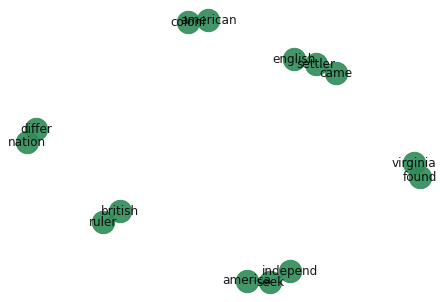

['settlers', 'seeking']

In [103]:
# Test Run
extract_keywords_with_text_rank(text, show_graph=True)

## Rake Algorithm

In [300]:
# Parameters to tune
# https://pypi.org/project/rake-nltk/
def extract_keywords_with_rake(sentences, stopwords=None, print_time=True, period_split=False, ranking_metric=Metric.WORD_DEGREE):
    with Timer("Rake", print_time):
        rake = None
        if stopwords is not None:
            rake = Rake(stopwords=stopwords, ranking_metric=ranking_metric)
        else:
            rake = Rake(ranking_metric=ranking_metric)
        
        if period_split:
            rake.extract_keywords_from_text(".".join(sentences))
        else:
            rake.extract_keywords_from_text(" ".join(sentences))
    return rake.get_ranked_phrases()[:4]

In [229]:
# Test Run
extract_keywords_with_rake(text)

[Timer] Rake Function took 0.0011405669938540086


['early 1600s english settlers came',
 'many different nations',
 'first american colony',
 'america seeking independence']

## Bert Algorithm

In [107]:
def extract_keywords_with_bert(sentences, n_gram=(1,1), use_stop_words=True, model_name='distilbert-base-nli-mean-tokens', print_time=True):
    with Timer("Bert", print_time):
        n_gram_range = n_gram

        stop_words = []
        if use_stop_words:
            stop_words = 'english'

        # Extract candidate words/phrases
        count = CountVectorizer(ngram_range=n_gram_range, stop_words=stop_words).fit(sentences)
        candidates = count.get_feature_names()

        model = SentenceTransformer(model_name)
        doc_embedding = model.encode(sentences, convert_to_tensor=True)
        candidate_embeddings = model.encode(candidates, convert_to_tensor=True)

        cosine_scores = util.pytorch_cos_sim(doc_embedding, candidate_embeddings)

    keywords = [candidates[index] for index in cosine_scores.argsort()[0][-5:]]
    return keywords[:5]

In [108]:
# Test Run
extract_keywords_with_bert(text)

[Timer] Bert Function took 1.7048271319981723


['settlers', 'british', 'english', '1607', '1600s']

In [42]:
video_id = "vd0fMpAIs1s"
timestamp = 90
duration = 255
text = get_caption_segment(video_id, timestamp, duration, delta = 10)

In [43]:
text

['back in the early 1600s English settlers',
 'came to America',
 'seeking independence from British rulers',
 'they founded Virginia the first American',
 'colony in 1607 settlers from many',
 'different nations such as Sweden and']

[Timer] Bert Function took 1.2341444819999197
['settlers', 'british', 'english', '1607', '1600s']
[Timer] Bert Function took 1.6987837309998213
['in 1607 settlers', 'english settlers', '1600s english', 'early 1600s english', '1600s english settlers']
[Timer] Bert Function took 2.4057032389996493
['british', 'english', 'settlers', '1607', '1600s']
[Timer] Bert Function took 3.205275719999918
['the early 1600s', '1600s english', 'english settlers', 'early 1600s english', '1600s english settlers']
[Timer] Bert Function took 2.55857854199985
['early', '1607', 'settlers', 'english', '1600s']
[Timer] Bert Function took 3.602212623000014
['the early 1600s', 'english settlers', '1600s english', 'early 1600s english', '1600s english settlers']
[Timer] Bert Function took 5.909974878999947
['english', 'british', 'settlers', '1607', '1600s']
[Timer] Bert Function took 6.744863056999748
['in 1607 settlers', 'english settlers', '1600s english', 'early 1600s english', '1600s english settlers']
[Timer

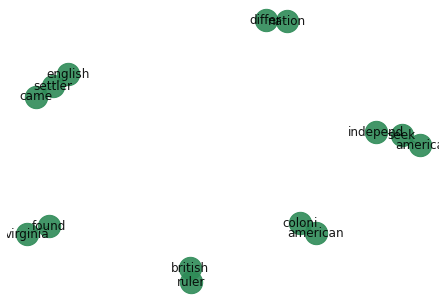

[Timer] TFIDF Function took 0.0036547930003507645
           TF-IDF
1600s    0.407662
back     0.407662
early    0.407662
english  0.407662
in       0.334289


In [53]:
extract_keywords_with_bert(text, (1, 1), use_stop_words=True)
extract_keywords_with_bert(text, (1, 3), use_stop_words=False)
extract_keywords_with_bert(text, (1, 1), use_stop_words=True, model_name="bert-base-nli-stsb-mean-tokens") # About 450 MB in size
extract_keywords_with_bert(text, (1, 3), use_stop_words=False, model_name="bert-base-nli-stsb-mean-tokens")
extract_keywords_with_bert(text, (1, 1), use_stop_words=True, model_name="roberta-base-nli-stsb-mean-tokens") # About 460 MB in size
extract_keywords_with_bert(text, (1, 3), use_stop_words=False, model_name="roberta-base-nli-stsb-mean-tokens")
extract_keywords_with_bert(text, (1, 1), use_stop_words=True, model_name="xlm-r-bert-base-nli-stsb-mean-tokens") # About 1 GB in size
extract_keywords_with_bert(text, (1, 3), use_stop_words=False, model_name="xlm-r-bert-base-nli-stsb-mean-tokens")
extract_keywords_with_bert(text, (1, 1), use_stop_words=True, model_name="distilroberta-base-paraphrase-v1") # About 1 GB in size
extract_keywords_with_bert(text, (1, 3), use_stop_words=False, model_name="distilroberta-base-paraphrase-v1")

extract_keywords_with_rake(text)
extract_keywords_with_text_rank(text)
extract_keyword_with_tfidf(text)

In [34]:
fixed_text = [
    'back in the early 1600s',
    'English settlers came to America, seeking independence from British rulers.',
    'they founded Virginia the first American colony in 1607.'
]

[Timer] Bert Function took 1.1704183720000287
['came', 'founded', 'early', '1607', '1600s']
[Timer] Rake Function took 0.0008272499999861793
[(25.0, 'early 1600s english settlers came'), (9.0, 'first american colony'), (4.0, 'seeking independence'), (4.0, 'founded virginia')]
[Timer] TextRank Function took 0.003032516000018859
settlers
seeking


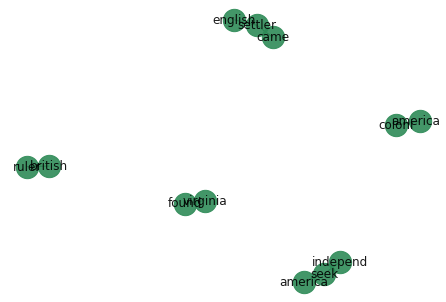

[Timer] TFIDF Function took 0.003439569000022402
           TF-IDF
1600s    0.409865
back     0.409865
early    0.409865
english  0.409865
in       0.330677


In [35]:
extract_keywords_with_bert(fixed_text, (1, 1), use_stop_words=True)
extract_keywords_with_rake(fixed_text)
extract_keywords_with_text_rank(fixed_text)
extract_keyword_with_tfidf(fixed_text)

In [261]:
video_id = "VPdE5aOH52g"
timestamp = 180
duration = 356
text = get_caption_segment(video_id, timestamp, duration, delta = 10)

In [262]:
text

['see a four of the tens place I know if',
 "it's 4 or lower we have to round down",
 'the prayer in the hundreds place is',
 'underlined so we have to round the 4 in',
 'the hundreds place to 400 when rounding',
 'to the hundreds place the number in the',
 'tens in ones place becomes zeros',
 'now I know about 400 pieces of fruit for']

In [263]:
extract_keywords_with_bert([" ".join(text)], (1, 3), use_stop_words=False)

[Timer] Bert Function took 2.029727892993833
['400 when', 'to 400', 'about 400', 'place to 400', 'to 400 when']


In [264]:
extract_keywords_with_rake(text)

[(14.666666666666666, 'ones place becomes zeros'), (4.666666666666666, 'hundreds place'), (4.166666666666666, 'tens place'), (3.5, '400 pieces')]
[Timer] Rake Function took 0.001994054007809609


## Testing Dataset

In [144]:
df = pd.read_csv('filtered_data.csv')
df.head()

,Unnamed: 0,searchTerms,snippet
0,0,flights to hong kong,Book Cheap Flights to Hong Kong: Search and co...
1,1,flights to hong kong,Find flights to Hong Kong on Hong Kong Airline...
2,2,flights to hong kong,Find & book great deals on Hong Kong (HKG) Fli...
3,3,flights to hong kong,Flights to Hong Kong SAR from airlines such as...
4,4,flights to hong kong,"Aug 15, 2019 ... Flights are resuming after pr..."


In [145]:
def convert(raw_string):
    raw_string = raw_string.replace('\xa0...', '')
    raw_string = raw_string.replace('xa0...', '')
    raw_string = raw_string.replace("?", ".")
    raw_string = raw_string.replace('\n', '')
    sentences = raw_string.split('. ')
    
    return list(filter(lambda e: len(e) > 0, sentences))

In [146]:
raw_snippet_list = df['snippet'].to_list()
filtered_snippet_list = list(map(convert, raw_snippet_list))

keyword = df['searchTerms'].tolist()
print("{} vs {}".format(len(filtered_snippet_list), len(keyword)))

448 vs 448


## Benchmark Ultility

In [271]:
def evaluate_algorithm(name, func, arguments, delta=10, print_x=False):
    wrongs = []
    wrongs_x = []
    rights = []
    rights_x = []

    with Timer(name):
        counter = 0
        process_count = 0
        total_count = len(keyword)
        
        for x, y in zip(filtered_snippet_list, keyword):
            if process_count % 50 == 0:
                print('Finished {} out of {}'.format(process_count, total_count))
    
            result = func(x, **arguments)
            process_count += 1

            for res in result:
                if distance(y, res) < delta:
                    counter += 1
                    if len(rights) < 10:
                        rights.append("{} ------- {}".format(result, y))
                        rights_x.append(x)
                    break
                else:
                    if len(wrongs) < 10:
                        wrongs.append("{} ------- {}".format(result, y))
                        wrongs_x.append(x)
    print("\n\nResult")
    print("Accuracy {}".format(counter / total_count))
    print()
    print("Wrong examples.")
    print(wrongs)
    print()
    print("Right examples.")
    print(rights)
    print()
    
    if print_x:
        print(wrongs_x)
        print()
        print(rights_x)

## Run benchmarks and tune

In [301]:
evaluate_algorithm(
    "Rake",
    extract_keywords_with_rake,
    {
        "print_time": False,
        "period_split": True
    }
)

Finished 0 out of 448
Finished 50 out of 448
Finished 100 out of 448
Finished 150 out of 448
Finished 200 out of 448
Finished 250 out of 448
Finished 300 out of 448
Finished 350 out of 448
Finished 400 out of 448
[Timer] Rake Function took 0.1888364409969654


Result
Accuracy 0.05803571428571429

Wrong examples.
["['book cheap flights', 'best flights', 'best airline', 'hong kong'] ------- flights to hong kong", "['book cheap flights', 'best flights', 'best airline', 'hong kong'] ------- flights to hong kong", "['book cheap flights', 'best flights', 'best airline', 'hong kong'] ------- flights to hong kong", "['book cheap flights', 'best flights', 'best airline', 'hong kong'] ------- flights to hong kong", "['hong kong airlines', 'hong kong', 'san francisco', 'new york'] ------- flights to hong kong", "['hong kong airlines', 'hong kong', 'san francisco', 'new york'] ------- flights to hong kong", "['hong kong airlines', 'hong kong', 'san francisco', 'new york'] ------- flights to hong k

### Rake executed very fast with a low accuracy. Although Rake is able to capture the main theme on flights, it is only half way accurate since it does not capture the destination/action. This is the expected behavior of Rake considering that `to` is being considered as a stopword and removed. Thus, Rake is not expected to capture the underlying relationship. Next, we will tune this algorithm by overriding the `stopwords` constraint

In [302]:
# Using a tight delta causes accuracy drop
evaluate_algorithm(
    "Rake",
    extract_keywords_with_rake,
    {
        "print_time": False,
        "stopwords": ["and", "on", "for", "the"],
        "period_split": True
#         "ranking_metric": Metric.WORD_DEGREE
    },
    print_x=True
)

Finished 0 out of 448
Finished 50 out of 448
Finished 100 out of 448
Finished 150 out of 448
Finished 200 out of 448
Finished 250 out of 448
Finished 300 out of 448
Finished 350 out of 448
Finished 400 out of 448
[Timer] Rake Function took 0.1096584719925886


Result
Accuracy 0.5290178571428571

Wrong examples.
["['book cheap flights to hong kong', 'your trip to hong kong', 'tripadvisor to find', 'best flights'] ------- flights to hong kong", "['trip from san francisco from', 'from new york from', 'find flights to hong kong', 'hong kong airlines'] ------- flights to hong kong", "['trip from san francisco from', 'from new york from', 'find flights to hong kong', 'hong kong airlines'] ------- flights to hong kong", "['fly to hong kong with cathay pacific', 'hong kong', 'book great deals', 'winning service'] ------- flights to hong kong", "['fly to hong kong with cathay pacific', 'hong kong', 'book great deals', 'winning service'] ------- flights to hong kong", "['fly to hong kong with ca

#### Bad examples are not neccessarily bad, let's descrease the contrainst to count those

In [304]:
evaluate_algorithm(
    "Rake",
    extract_keywords_with_rake,
    {
        "print_time": False,
        "stopwords": ["and", "on", "for", "the"],
        "period_split": True
#         "ranking_metric": Metric.WORD_DEGREE
    },
    delta=15,
    print_x=True
)

Finished 0 out of 448
Finished 50 out of 448
Finished 100 out of 448
Finished 150 out of 448
Finished 200 out of 448
Finished 250 out of 448
Finished 300 out of 448
Finished 350 out of 448
Finished 400 out of 448
[Timer] Rake Function took 0.09545866500411648


Result
Accuracy 0.7522321428571429

Wrong examples.
["['trip from san francisco from', 'from new york from', 'find flights to hong kong', 'hong kong airlines'] ------- flights to hong kong", "['trip from san francisco from', 'from new york from', 'find flights to hong kong', 'hong kong airlines'] ------- flights to hong kong", "['fly to hong kong with cathay pacific', 'hong kong', 'book great deals', 'winning service'] ------- flights to hong kong", "['flights to hong kong sar from airlines such as american airlines', 'hotel to save up to 100', 'book your flight', 'your'] ------- flights to hong kong", "['flights to hong kong sar from airlines such as american airlines', 'hotel to save up to 100', 'book your flight', 'your'] ---

#### By supplying a custom stopword list, we can see a huge jump in accuracy. In particular, we are seeing that the relationship is now captured in the algorithm even though rake is purely based on stats instead of underlying context\

https://medium.com/datadriveninvestor/rake-rapid-automatic-keyword-extraction-algorithm-f4ec17b2886c Rake explained

#### Next TFIDF

In [262]:
evaluate_algorithm(
    "TFIDF",
    extract_keyword_with_tfidf,
    {
        "print_time": False,
        "use_stopwords": True,
        "ngram_range": (1, 4)
    }
)

Finished 0 out of 448
Finished 50 out of 448
Finished 100 out of 448
Finished 150 out of 448
Finished 200 out of 448
Finished 250 out of 448
Finished 300 out of 448
Finished 350 out of 448
Finished 400 out of 448
[Timer] TFIDF Function took 1.0967868769948836


Result
Accuracy 0.5290178571428571

Wrong examples.
["['flights', 'hong', 'hong kong', 'kong', 'kong search compare'] ------- flights to hong kong", "['flights', 'hong', 'hong kong', 'kong', 'kong search compare'] ------- flights to hong kong", "['flights', 'hong', 'hong kong', 'kong', 'kong search compare'] ------- flights to hong kong", "['flights', 'hong', 'hong kong', 'kong', 'kong search compare'] ------- flights to hong kong", "['flights', 'hong', 'hong kong', 'kong', 'kong search compare'] ------- flights to hong kong", "['kong', 'hong kong', 'hong', 'hong kong hong kong', 'hong kong airlines xiamenair'] ------- flights to hong kong", "['kong', 'hong kong', 'hong', 'hong kong hong kong', 'hong kong airlines xiamenair'] --

In [298]:
evaluate_algorithm(
    "TFIDF",
    extract_keyword_with_tfidf,
    {
        "print_time": False,
        "ngram_range": (1, 4)
    },
    print_x=True
)

Finished 0 out of 448
Finished 50 out of 448
Finished 100 out of 448
Finished 150 out of 448
Finished 200 out of 448
Finished 250 out of 448
Finished 300 out of 448
Finished 350 out of 448
Finished 400 out of 448
[Timer] TFIDF Function took 1.0084415260062087


Result
Accuracy 0.5982142857142857

Wrong examples.
["['to', 'to hong kong', 'flights', 'hong', 'hong kong'] ------- flights to hong kong", "['hong', 'hong kong', 'kong', 'to hong kong on', 'flights to hong'] ------- flights to hong kong", "['hong', 'hong kong', 'kong', 'to hong kong on', 'flights to hong'] ------- flights to hong kong", "['hong', 'hong kong', 'kong', 'to hong kong on', 'flights to hong'] ------- flights to hong kong", "['hong', 'hong kong', 'kong', 'to hong kong on', 'flights to hong'] ------- flights to hong kong", "['great deals on', 'deals on hong kong', 'find book great', 'find book great deals', 'flights'] ------- flights to hong kong", "['airlines', 'from airlines', 'hong kong sar', 'flights to', 'flights

#### TDIDF performed decently and benefits from not using stopwords, but suffers from low quality keyword answers

see pros and cons here https://nzmattgrant.wordpress.com/2018/01/31/a-comparison-of-rake-and-tf-idf-algorithms-for-finding-keywords-in-text/

### Onward, TextRank

In [273]:
evaluate_algorithm(
    "Text Rank",
    extract_keywords_with_text_rank,
    {
        "print_time": False
    },
    print_x=True
)

Finished 0 out of 448
Finished 50 out of 448
Finished 100 out of 448
Finished 150 out of 448
Finished 200 out of 448
Finished 250 out of 448
Finished 300 out of 448
Finished 350 out of 448
Finished 400 out of 448
[Timer] Text Rank Function took 0.9840842479970888


Result
Accuracy 0.09151785714285714

Wrong examples.
["['kong', 'cheap'] ------- flights to hong kong", "['kong', 'cheap'] ------- flights to hong kong", "['round', 'air'] ------- flights to hong kong", "['round', 'air'] ------- flights to hong kong", "['great'] ------- flights to hong kong", "['kong', 'airlines'] ------- flights to hong kong", "['kong', 'airlines'] ------- flights to hong kong", "['kong'] ------- flights to hong kong", "['kong', 'comparison'] ------- flights to hong kong", "['kong', 'comparison'] ------- flights to hong kong"]

Right examples.
["['flights', 'flight ticket'] ------- flights to bangkok", "['flights', 'flight ticket'] ------- flights to london", "['flights', 'flight'] ------- flights to macau"

[Timer] TextRank Function took 0.005747667994000949


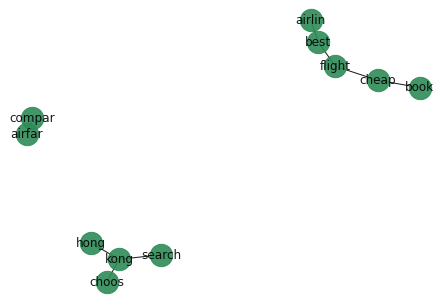

['kong', 'best']

In [281]:
extract_keywords_with_text_rank(
    ['Book Cheap Flights to Hong Kong: Search and compare airfares on TripAdvisor to find the best flights for your trip to Hong Kong', 'Choose the best airline for you','Book Cheap Flights to Hong Kong: Search and compare airfares on TripAdvisor to find the best flights for your trip to Hong Kong', 'Choose the best airline for you'],
    show_graph=True)

## Onward, BERT

In [283]:
evaluate_algorithm(
    "Text Rank",
    extract_keywords_with_bert,
    {
        "n_gram": (1, 1),
        "use_stop_words": True,
        "print_time": False
    },
)

Finished 0 out of 448
Finished 50 out of 448
Finished 100 out of 448
Finished 150 out of 448
Finished 200 out of 448
Finished 250 out of 448
Finished 300 out of 448
Finished 350 out of 448
Finished 400 out of 448
[Timer] Text Rank Function took 533.5712783039999


Result
Accuracy 0.203125

Wrong examples.
["['trip', 'flights', 'airfares', 'cheap', 'airline'] ------- flights to hong kong", "['trip', 'flights', 'airfares', 'cheap', 'airline'] ------- flights to hong kong", "['trip', 'flights', 'airfares', 'cheap', 'airline'] ------- flights to hong kong", "['trip', 'flights', 'airfares', 'cheap', 'airline'] ------- flights to hong kong", "['trip', 'flights', 'airfares', 'cheap', 'airline'] ------- flights to hong kong", "['kong', 'flights', 'china', 'xiamenair', 'airlines'] ------- flights to hong kong", "['kong', 'flights', 'china', 'xiamenair', 'airlines'] ------- flights to hong kong", "['kong', 'flights', 'china', 'xiamenair', 'airlines'] ------- flights to hong kong", "['kong', 'fli

In [286]:
evaluate_algorithm(
    "Bert",
    extract_keywords_with_bert,
    {
        "n_gram": (1, 3),
        "print_time": False
    },
    print_x=True
)

Finished 0 out of 448
Finished 50 out of 448
Finished 100 out of 448
Finished 150 out of 448
Finished 200 out of 448
Finished 250 out of 448
Finished 300 out of 448
Finished 350 out of 448
Finished 400 out of 448
[Timer] Bert Function took 643.7831601470025


Result
Accuracy 0.6651785714285714

Wrong examples.
["['choose best airline', 'best flights trip', 'cheap flights hong', 'book cheap flights', 'tripadvisor best flights'] ------- flights to hong kong", "['choose best airline', 'best flights trip', 'cheap flights hong', 'book cheap flights', 'tripadvisor best flights'] ------- flights to hong kong", "['choose best airline', 'best flights trip', 'cheap flights hong', 'book cheap flights', 'tripadvisor best flights'] ------- flights to hong kong", "['choose best airline', 'best flights trip', 'cheap flights hong', 'book cheap flights', 'tripadvisor best flights'] ------- flights to hong kong", "['choose best airline', 'best flights trip', 'cheap flights hong', 'book cheap flights', '

In [288]:
evaluate_algorithm(
    "Bert",
    extract_keywords_with_bert,
    {
        "n_gram": (1, 3),
        "print_time": False
    },
    delta=15,
    print_x=True
)

Finished 0 out of 448
Finished 50 out of 448
Finished 100 out of 448
Finished 150 out of 448
Finished 200 out of 448
Finished 250 out of 448
Finished 300 out of 448
Finished 350 out of 448
Finished 400 out of 448
[Timer] Bert Function took 572.3377663680003


Result
Accuracy 0.8861607142857143

Wrong examples.
["['choose best airline', 'best flights trip', 'cheap flights hong', 'book cheap flights', 'tripadvisor best flights'] ------- flights to hong kong", "['choose best airline', 'best flights trip', 'cheap flights hong', 'book cheap flights', 'tripadvisor best flights'] ------- flights to hong kong", "['xiamenair air china', 'kong airlines', 'flights hong kong', 'hong kong airlines', 'kong airlines xiamenair'] ------- flights to hong kong", "['xiamenair air china', 'kong airlines', 'flights hong kong', 'hong kong airlines', 'kong airlines xiamenair'] ------- flights to hong kong", "['book great deals', 'fly hong kong', 'kong hkg flights', 'deals hong kong', 'great deals hong'] -----

#### bert-base-nli-stsb-mean-tokens

In [289]:
evaluate_algorithm(
    "Bert",
    extract_keywords_with_bert,
    {
        "n_gram": (1, 3),
        "print_time": False,
        "model_name": "xlm-r-bert-base-nli-stsb-mean-tokens"
    },
    print_x=True
)

Finished 0 out of 448
Finished 50 out of 448
Finished 100 out of 448
Finished 150 out of 448
Finished 200 out of 448
Finished 250 out of 448
Finished 300 out of 448
Finished 350 out of 448
Finished 400 out of 448
[Timer] Bert Function took 2936.9500789929953


Result
Accuracy 0.7410714285714286

Wrong examples.
["['best flights', 'best flights trip', 'cheap flights', 'cheap flights hong', 'book cheap flights'] ------- flights to hong kong", "['best flights', 'best flights trip', 'cheap flights', 'cheap flights hong', 'book cheap flights'] ------- flights to hong kong", "['best flights', 'best flights trip', 'cheap flights', 'cheap flights hong', 'book cheap flights'] ------- flights to hong kong", "['best flights', 'best flights trip', 'cheap flights', 'cheap flights hong', 'book cheap flights'] ------- flights to hong kong", "['best flights', 'best flights trip', 'cheap flights', 'cheap flights hong', 'book cheap flights'] ------- flights to hong kong", "['airlines', 'airlines america

In [290]:
evaluate_algorithm(
    "Bert",
    extract_keywords_with_bert,
    {
        "n_gram": (1, 3),
        "print_time": False,
        "model_name": "xlm-r-bert-base-nli-stsb-mean-tokens"
    },
    delta=15,
    print_x=True
)

Finished 0 out of 448
Finished 50 out of 448
Finished 100 out of 448
Finished 150 out of 448
Finished 200 out of 448
Finished 250 out of 448
Finished 300 out of 448
Finished 350 out of 448
Finished 400 out of 448
[Timer] Bert Function took 2924.374861575998


Result
Accuracy 0.9040178571428571

Wrong examples.
["['best flights', 'best flights trip', 'cheap flights', 'cheap flights hong', 'book cheap flights'] ------- flights to hong kong", "['best flights', 'best flights trip', 'cheap flights', 'cheap flights hong', 'book cheap flights'] ------- flights to hong kong", "['best flights', 'best flights trip', 'cheap flights', 'cheap flights hong', 'book cheap flights'] ------- flights to hong kong", "['airlines', 'airlines american airlines', 'flights hong', 'flights hong kong', 'kong sar airlines'] ------- flights to hong kong", "['airlines', 'airlines american airlines', 'flights hong', 'flights hong kong', 'kong sar airlines'] ------- flights to hong kong", "['2019', '15', 'aug 15', '1

### roberta-base-nli-stsb-mean-tokens

In [291]:
evaluate_algorithm(
    "Bert",
    extract_keywords_with_bert,
    {
        "n_gram": (1, 3),
        "print_time": False,
        "model_name": "roberta-base-nli-stsb-mean-tokens"
    },
    print_x=True
)

Finished 0 out of 448
Finished 50 out of 448
Finished 100 out of 448
Finished 150 out of 448
Finished 200 out of 448
Finished 250 out of 448
Finished 300 out of 448
Finished 350 out of 448
Finished 400 out of 448
[Timer] Bert Function took 1230.1289690859994


Result
Accuracy 0.7879464285714286

Wrong examples.
["['compare airfares tripadvisor', 'flights hong kong', 'book cheap flights', 'flights trip hong', 'cheap flights hong'] ------- flights to hong kong", "['kong airlines xiamenair', 'kong airlines', 'flights hong', 'flights hong kong', 'hong kong airlines'] ------- flights to hong kong", "['kong airlines xiamenair', 'kong airlines', 'flights hong', 'flights hong kong', 'hong kong airlines'] ------- flights to hong kong", "['kong sar', 'hong kong sar', 'flights hong', 'flights hong kong', 'kong sar airlines'] ------- flights to hong kong", "['kong sar', 'hong kong sar', 'flights hong', 'flights hong kong', 'kong sar airlines'] ------- flights to hong kong", "['2019', '15', 'aug 15

In [308]:
evaluate_algorithm(
    "Bert",
    extract_keywords_with_bert,
    {
        "n_gram": (1, 3),
        "print_time": False,
        "model_name": "roberta-large-nli-stsb-mean-tokens"
    },
    print_x=True
)

Finished 0 out of 448
Finished 50 out of 448
Finished 100 out of 448
Finished 150 out of 448
Finished 200 out of 448
Finished 250 out of 448
Finished 300 out of 448
Finished 350 out of 448
Finished 400 out of 448
[Timer] Bert Function took 5269.899526319015


Result
Accuracy 0.7589285714285714

Wrong examples.
["['cheap flights', 'search compare airfares', 'airfares tripadvisor best', 'book cheap flights', 'cheap flights hong'] ------- flights to hong kong", "['cheap flights', 'search compare airfares', 'airfares tripadvisor best', 'book cheap flights', 'cheap flights hong'] ------- flights to hong kong", "['cheap flights', 'search compare airfares', 'airfares tripadvisor best', 'book cheap flights', 'cheap flights hong'] ------- flights to hong kong", "['cheap flights', 'search compare airfares', 'airfares tripadvisor best', 'book cheap flights', 'cheap flights hong'] ------- flights to hong kong", "['cheap flights', 'search compare airfares', 'airfares tripadvisor best', 'book cheap 

### bert-base-nli-stsb-mean-tokens

In [293]:
evaluate_algorithm(
    "Bert",
    extract_keywords_with_bert,
    {
        "n_gram": (1, 3),
        "print_time": False,
        "model_name": "bert-base-nli-stsb-mean-tokens"
    },
    print_x=True
)

Finished 0 out of 448
Finished 50 out of 448
Finished 100 out of 448
Finished 150 out of 448
Finished 200 out of 448
Finished 250 out of 448
Finished 300 out of 448
Finished 350 out of 448
Finished 400 out of 448
[Timer] Bert Function took 1054.062828424001


Result
Accuracy 0.7321428571428571

Wrong examples.
["['tripadvisor best flights', 'best flights trip', 'cheap flights', 'cheap flights hong', 'book cheap flights'] ------- flights to hong kong", "['tripadvisor best flights', 'best flights trip', 'cheap flights', 'cheap flights hong', 'book cheap flights'] ------- flights to hong kong", "['tripadvisor best flights', 'best flights trip', 'cheap flights', 'cheap flights hong', 'book cheap flights'] ------- flights to hong kong", "['tripadvisor best flights', 'best flights trip', 'cheap flights', 'cheap flights hong', 'book cheap flights'] ------- flights to hong kong", "['tripadvisor best flights', 'best flights trip', 'cheap flights', 'cheap flights hong', 'book cheap flights'] ---

In [306]:
evaluate_algorithm(
    "Bert",
    extract_keywords_with_bert,
    {
        "n_gram": (1, 4),
        "print_time": False,
        "model_name": "bert-base-nli-stsb-mean-tokens"
    },
    print_x=True
)

Finished 0 out of 448


  1%|▏         | 16.1M/1.24G [00:26<07:05, 2.89MB/s]

[Timer] Bert Function took 102.43539714800136


KeyboardInterrupt: 

### distilroberta-base-paraphrase-v1

In [295]:
evaluate_algorithm(
    "Bert",
    extract_keywords_with_bert,
    {
        "n_gram": (1, 3),
        "print_time": False,
        "model_name": "distilroberta-base-paraphrase-v1"
    },
    print_x=True
)

Finished 0 out of 448
Finished 50 out of 448
Finished 100 out of 448
Finished 150 out of 448
Finished 200 out of 448
Finished 250 out of 448
Finished 300 out of 448
Finished 350 out of 448
Finished 400 out of 448
[Timer] Bert Function took 780.7040364599961


Result
Accuracy 0.6875

Wrong examples.
["['hong kong hkg', 'deals hong kong', 'great deals hong', 'fly hong kong', 'kong hkg flights'] ------- flights to hong kong", "['15', '2019', 'aug 15', '15 2019', 'aug 15 2019'] ------- flights to hong kong", "['15', '2019', 'aug 15', '15 2019', 'aug 15 2019'] ------- flights to hong kong", "['15', '2019', 'aug 15', '15 2019', 'aug 15 2019'] ------- flights to hong kong", "['15', '2019', 'aug 15', '15 2019', 'aug 15 2019'] ------- flights to hong kong", "['15', '2019', 'aug 15', '15 2019', 'aug 15 2019'] ------- flights to hong kong", "['kong intl hkg', 'cheap flights', 'flights hong kong', 'skyscanner flight comparison', 'cheap flights hong'] ------- flights to hong kong", "['kong intl hkg

In [296]:
evaluate_algorithm(
    "Bert",
    extract_keywords_with_bert,
    {
        "n_gram": (1, 3),
        "print_time": False,
        "model_name": "distilroberta-base-paraphrase-v1"
    },
    delta=15,
    print_x=True
)

Finished 0 out of 448
Finished 50 out of 448
Finished 100 out of 448
Finished 150 out of 448
Finished 200 out of 448
Finished 250 out of 448
Finished 300 out of 448
Finished 350 out of 448
Finished 400 out of 448
[Timer] Bert Function took 781.082566549012


Result
Accuracy 0.921875

Wrong examples.
["['15', '2019', 'aug 15', '15 2019', 'aug 15 2019'] ------- flights to hong kong", "['15', '2019', 'aug 15', '15 2019', 'aug 15 2019'] ------- flights to hong kong", "['15', '2019', 'aug 15', '15 2019', 'aug 15 2019'] ------- flights to hong kong", "['15', '2019', 'aug 15', '15 2019', 'aug 15 2019'] ------- flights to hong kong", "['15', '2019', 'aug 15', '15 2019', 'aug 15 2019'] ------- flights to hong kong", "['14', 'aug 14', '2019', '14 2019', 'aug 14 2019'] ------- flights to hong kong", "['14', 'aug 14', '2019', '14 2019', 'aug 14 2019'] ------- flights to hong kong", "['14', 'aug 14', '2019', '14 2019', 'aug 14 2019'] ------- flights to hong kong", "['14', 'aug 14', '2019', '14 2019

In [ ]:
[
    'Book Cheap Flights to Hong Kong: Search and compare airfares on TripAdvisor to find the best flights for your trip to Hong Kong',
    'Choose the best airline for you'
]